In [2]:
!python --version


Python 3.11.8


In [12]:
# 🛠️ Step 1: Set up Spark Session
# Install pyspark if not already installed
%pip install pyspark

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MallCustomersAnalysis").getOrCreate()

print("✅ Spark Session Created")
print(f"Spark Version: {spark.version}")

Note: you may need to restart the kernel to use updated packages.
✅ Spark Session Created
Spark Version: 3.5.5


In [13]:
# Update the file path to the correct location of the dataset
df = spark.read.csv("/mnt/c/Users/hmdkr/DE-Projects/mall-customers/data/Mall_Customers.csv", header=True, inferSchema=True)
df.show(5)
df.printSchema()

+----------+------+---+------------------+----------------------+
|CustomerID| Genre|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|         1|  Male| 19|                15|                    39|
|         2|  Male| 21|                15|                    81|
|         3|Female| 20|                16|                     6|
|         4|Female| 23|                16|                    77|
|         5|Female| 31|                17|                    40|
+----------+------+---+------------------+----------------------+
only showing top 5 rows

root
 |-- CustomerID: integer (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Annual Income (k$): integer (nullable = true)
 |-- Spending Score (1-100): integer (nullable = true)



In [14]:
# 🛠️ 3. Basic EDA
print("✅ Summary Statistics:")
df.describe().show()

✅ Summary Statistics:


25/04/28 22:49:44 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------+-----------------+------------------+----------------------+
|summary|        CustomerID| Genre|              Age|Annual Income (k$)|Spending Score (1-100)|
+-------+------------------+------+-----------------+------------------+----------------------+
|  count|               200|   200|              200|               200|                   200|
|   mean|             100.5|  NULL|            38.85|             60.56|                  50.2|
| stddev|57.879184513951124|  NULL|13.96900733155888| 26.26472116527124|    25.823521668370173|
|    min|                 1|Female|               18|                15|                     1|
|    max|               200|  Male|               70|               137|                    99|
+-------+------------------+------+-----------------+------------------+----------------------+



In [15]:
# 🛠️ 4. Group by Genre and calculate averages
print("✅ Average Annual Income and Spending Score by Gender:")
df.groupBy("Genre") \
    .avg("Annual Income (k$)", "Spending Score (1-100)") \
    .show()

✅ Average Annual Income and Spending Score by Gender:
+------+-----------------------+---------------------------+
| Genre|avg(Annual Income (k$))|avg(Spending Score (1-100))|
+------+-----------------------+---------------------------+
|Female|                  59.25|         51.526785714285715|
|  Male|      62.22727272727273|          48.51136363636363|
+------+-----------------------+---------------------------+



In [9]:
# 📥 Step 2: Load Dataset
# df = spark.read.csv("data/Mall_Customers.csv", header=True, inferSchema=True)
# df.printSchema()
# df.show(5)


In [10]:
# 📊 Step 3: Spending Score Distribution
df.groupBy("Spending Score (1-100)") \
  .count() \
  .orderBy("Spending Score (1-100)") \
  .show(20)


+----------------------+-----+
|Spending Score (1-100)|count|
+----------------------+-----+
|                     1|    2|
|                     3|    1|
|                     4|    2|
|                     5|    4|
|                     6|    2|
|                     7|    1|
|                     8|    1|
|                     9|    1|
|                    10|    2|
|                    11|    1|
|                    12|    1|
|                    13|    3|
|                    14|    4|
|                    15|    3|
|                    16|    2|
|                    17|    3|
|                    18|    1|
|                    20|    2|
|                    22|    1|
|                    23|    1|
+----------------------+-----+
only showing top 20 rows



In [11]:
# 📈 Step 4: Average Income by Spending Score
from pyspark.sql.functions import avg, count

df.groupBy("Spending Score (1-100)") \
  .agg(avg("Annual Income (k$)").alias("Avg Income"), count("*").alias("Count")) \
  .orderBy("Spending Score (1-100)") \
  .show(20)


+----------------------+-----------------+-----+
|Spending Score (1-100)|       Avg Income|Count|
+----------------------+-----------------+-----+
|                     1|             78.0|    2|
|                     3|             19.0|    1|
|                     4|             31.5|    2|
|                     5|             63.5|    4|
|                     6|             17.0|    2|
|                     7|             73.0|    1|
|                     8|            113.0|    1|
|                     9|             71.0|    1|
|                    10|             80.5|    2|
|                    11|             71.0|    1|
|                    12|             77.0|    1|
|                    13|             65.0|    3|
|                    14|            43.25|    4|
|                    15|68.66666666666667|    3|
|                    16|             99.0|    2|
|                    17|71.66666666666667|    3|
|                    18|            137.0|    1|
|                   

In [17]:
# 🛠️ 5. Optional: Convert to Pandas for plotting
%pip install pandas

pandas_df = df.toPandas()

  Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Note: you may need to restart the kernel to use updated packages.


  Using cached matplotlib-3.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.57.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (102 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pillow-11.2.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (8.9 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
Using cached contourpy-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (326 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.57.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.9 MB)
Usi

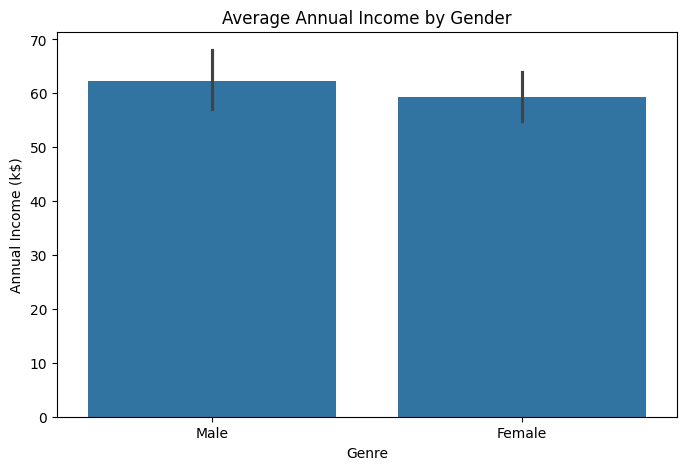

In [19]:
# Install matplotlib and seaborn if not already installed
%pip install matplotlib
%pip install seaborn

# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the data
plt.figure(figsize=(8,5))
sns.barplot(data=pandas_df, x="Genre", y="Annual Income (k$)")
plt.title("Average Annual Income by Gender")
plt.show()

## 🧠 Insights Summary

- Most customers fall into the middle range of spending scores.
- Income doesn't correlate directly with spending — some high spenders have moderate income.
- Segment opportunities:
  - **High Score + Low Income**: Loyal, budget-conscious
  - **High Score + High Income**: Premium target segment
